In previous notebooks, we have explored the core concepts behind `orcabridge` and how you can use that to define and execute computation pipeline, piecing together various operations (e.g., sources, mappers, and pods) via streams.

In this notebook, we will explore how `orcabridge` can integrate with DataJoint, particularly by seeing how one could automatically generate a functional DataJoint table-based pipeline that can be used to query computation results from the original `orcabridge` pipeline and furthermore, how the auto-generated DJ pipeline can be used to trigger computations in the original pipeline. 

Key to all of this is `Tracker` that we explored in the [previous notebook](./04_orcabridge_tracker.ipynb) that allows us to track computational graph for a pipeline. Using a special version of tracker called `QueryTracker` that can convert the tracked computation into a DataJoint tables!

## Defining the pipeline

As in previous notebooks, let's start by defining a concrete data pipeline in `orcabridge`.

In [ ]:
import json
import tempfile
from pathlib import Path

import yaml

from orcabridge.pod import function_pod
from orcabridge.source import GlobSource
from orcabridge.store import DirDataStore

# define data source
data_source = GlobSource(
    "data_file", "../examples/dataset1", "*.txt", label="LocalDataStore"
)

# use default data store location of `./pod_data`
data_store = DirDataStore()


# function to count lines in a file and save it as JSON
@function_pod(["stats"], data_store=data_store)
def count_lines(file: str):
    with open(file, "r") as f:
        n = len(f.readlines())
    tmp_dir = tempfile.mkdtemp()
    data_file = Path(tmp_dir) / "data.json"
    data = dict(lines=n)
    with open(data_file, "w") as f:
        json.dump(data, f)
    return data_file


@function_pod(["yaml_file"], data_store=data_store)
def json_to_yaml(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    tmp_dir = tempfile.mkdtemp()
    yaml_path = Path(tmp_dir) / Path(json_file).with_suffix(".yaml").name
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)
    return yaml_path


# function to extract keys from a JSON file and save them as a list in another JSON file
@function_pod(["key_info"], data_store=data_store)
def extract_keys(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    keys = list(data.keys())
    tmp_dir = tempfile.mkdtemp()
    keys_file = Path(tmp_dir) / "keys.json"
    with open(keys_file, "w") as f:
        json.dump(keys, f)
    return keys_file


import hashlib  # noqa: E402


@function_pod(["joint_hash"], data_store=data_store)
def joint_hash(file_path1: str, file_path2: str):
    """
    Hash the contents of two files, create a combined hash,
    and save it to a JSON file in a new temporary directory.

    Args:
        file_path1 (str): Path to the first file
        file_path2 (str): Path to the second file

    Returns:
        str: Path to the created JSON file
    """
    # Hash the first file
    with open(file_path1, "rb") as f:
        file1_content = f.read()
        file1_hash = hashlib.sha256(file1_content).hexdigest()

    # Hash the second file
    with open(file_path2, "rb") as f:
        file2_content = f.read()
        file2_hash = hashlib.sha256(file2_content).hexdigest()

    # Combine the hashes and create a new hash (like in a Merkle tree)
    combined_hash_input = file1_hash + file2_hash
    combined_hash = hashlib.sha256(combined_hash_input.encode()).hexdigest()

    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()

    # Create the JSON file path
    json_file_path = Path(temp_dir) / "hash_data.json"
    # Create and save the JSON file
    hash_data = {
        "joint_hash": combined_hash,  # corrected key from "hash_dat" to "hash_data"
        "file1_hash": file1_hash,
        "file2_hash": file2_hash,
    }

    with open(json_file_path, "w") as f:
        json.dump(hash_data, f, indent=4)

    return json_file_path

Before we chain them together into a pipeline, let's prepare the new tracker. Unlike regular `Tracker`, `QueryTracker` needs a few additional configuration in order for it to function.

In [2]:
import datajoint as dj

from orcabridge.dj.tracker import QueryTracker

schema = dj.schema("enigma_orcabridge_test")


tracker = QueryTracker()

[2025-05-05 03:18:41,126][INFO]: Connecting eywalker@at-database3.stanford.edu:3306
[2025-05-05 03:18:41,190][INFO]: Connected eywalker@at-database3.stanford.edu:3306


Now let's build the pipeline while tracking under the `QueryTracker`

In [3]:
with tracker:
    line_info_json = count_lines(data_source >> {"data_file": "file"})
    line_info_yaml = json_to_yaml(line_info_json >> {"stats": "json_file"})
    line_info_keys = extract_keys(line_info_json >> {"stats": "json_file"})
    joined_stream = line_info_yaml * line_info_keys
    joined_hash_data = joint_hash(
        joined_stream >> {"yaml_file": "file_path1", "key_info": "file_path2"}
    )
    final_files = count_lines(joined_hash_data >> {"joint_hash": "file"})

Let's make sure that the tracked computation graph looks good:

/home/eywalker/workspace/orcabridge/src/orcabridge/tracker.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


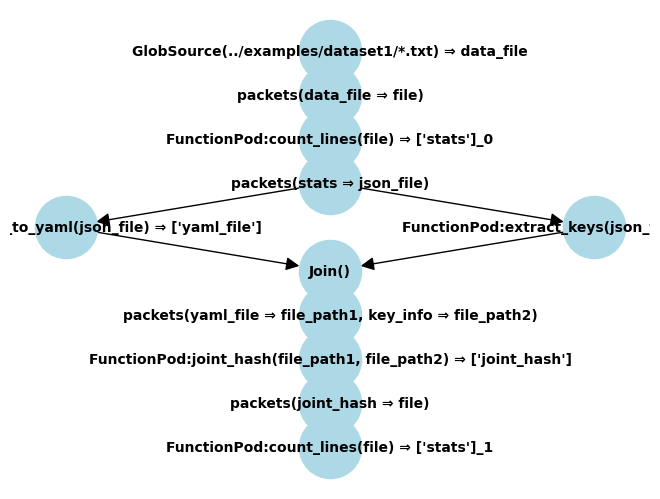

In [4]:
tracker.draw_graph()

Now comes the magical part -- generating the DataJoint tables from this graph.

In [5]:
G, module = tracker.generate_tables(schema)

Believe it or not, that was all that was needed to generate a full-fledged DataJoint pipeline that corresponds to our tracked `orcabridge` pipeline. The returned `module` object actually contains all the tables in the pipeline.

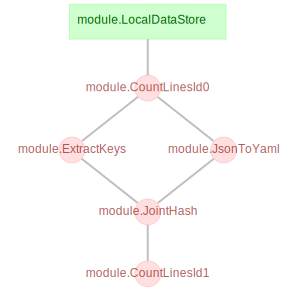

In [6]:
dj.Diagram(module)

You can see that the struture of the tables naturally correspond to our `orcabridge` pipeline from the above, but with some minor differences. Namely, all nodes corresponding to `Mappers` such as `MapPackets` and `Join` are missing. This is because in DataJoint, these operations are handled as defining characteristic of the connections between tables and don't really explicitly show up in the graph.

Let's now take a look at some of these tables!

In [7]:
module.LocalDataStore()

file_name,data_file


You might be wondering where is the data? If you were to look at the `data_source` that corresponds to our `LocalDataStore` table, there are certainly a few files present.

In [8]:
data_source.head(10)

Tag: {'file_name': 'day1'}, Packet: {'data_file': PosixPath('../examples/dataset1/day1.txt')}
Tag: {'file_name': 'day2'}, Packet: {'data_file': PosixPath('../examples/dataset1/day2.txt')}
Tag: {'file_name': 'day3'}, Packet: {'data_file': PosixPath('../examples/dataset1/day3.txt')}
Tag: {'file_name': 'day4'}, Packet: {'data_file': PosixPath('../examples/dataset1/day4.txt')}
Tag: {'file_name': 'day6'}, Packet: {'data_file': PosixPath('../examples/dataset1/day6.txt')}


Don't panic just yet! By default, DataJoint tables created to reflect `orcabridge` pipeline do *not* come prefilled with the results of the pipeline execution. Instead, you want to trigger the filling by calling `populate` on the table. Let's try filling the `LocalDataStore` table:

In [9]:
module.LocalDataStore().populate()

5

In [10]:
module.LocalDataStore()

file_name,data_file
day1,../examples/dataset1/day1.txt
day2,../examples/dataset1/day2.txt
day3,../examples/dataset1/day3.txt
day4,../examples/dataset1/day4.txt
day6,../examples/dataset1/day6.txt


Now you can see that the table was successfully filled with the files from the local glob-based data source (corresponding to `data_source`).

You can in fact trigger the computation in the downstream tables by calling `populate` on them! Let's go ahead and call `populate` on all tables, following the topographical order to ensure parent tables are populated before moving onto child tables.

In [11]:
module.LocalDataStore().populate()
module.CountLinesId0().populate()
module.ExtractKeys().populate()
module.JsonToYaml().populate()
module.JointHash().populate()
module.CountLinesId1().populate()

{'success_count': 5, 'error_list': []}

Now all tables are filled, having processed available contents. You might be happy to know that the underlying computation for each table is *memoized* and in fact shared with the `FunctionPod` based on which the table was created. Consequently, *populating* the tables actually have led to our original pipeline achieving memoization of all computations performed as part of the `populate` calls!

In [12]:
module.JsonToYaml()

file_name,yaml_file
day1,pod_data/json_to_yaml/0a2282eda2b641e6/6d0b282e-6970-a099-c1d7-632a66200b85/data.yaml
day2,pod_data/json_to_yaml/0a2282eda2b641e6/4ff1d406-4431-1849-9c36-266e39f1bbfd/data.yaml
day3,pod_data/json_to_yaml/0a2282eda2b641e6/d58c568b-7f44-f259-a195-94038e348017/data.yaml
day4,pod_data/json_to_yaml/0a2282eda2b641e6/14e16c5b-c470-66bc-b92a-7f1c09d091df/data.yaml
day6,pod_data/json_to_yaml/0a2282eda2b641e6/998c26f1-fc82-5d90-e25d-25f61f073189/data.yaml


In [13]:
module.CountLinesId1()

file_name,stats
day1,pod_data/count_lines/48028707c9dc37d7/8cd40c14-2c09-8a84-14e5-6c0b45f92cf7/data.json
day2,pod_data/count_lines/48028707c9dc37d7/1d1430e5-cc85-7005-b8ce-603963a825df/data.json
day3,pod_data/count_lines/48028707c9dc37d7/eda0b080-5b97-d917-1d53-ab4704e9e279/data.json
day4,pod_data/count_lines/48028707c9dc37d7/8df403a2-522c-208e-ecd8-53d146963c9f/data.json
day6,pod_data/count_lines/48028707c9dc37d7/79b8c697-920f-08eb-cfc6-499e810ab9d1/data.json
